In [146]:
import numpy as np
import pandas as pd
import cv2
import os
import glob
import matplotlib.pyplot as plt
import pickle

%matplotlib inline

Text(0.5, 1.0, 'Undistorted Image')

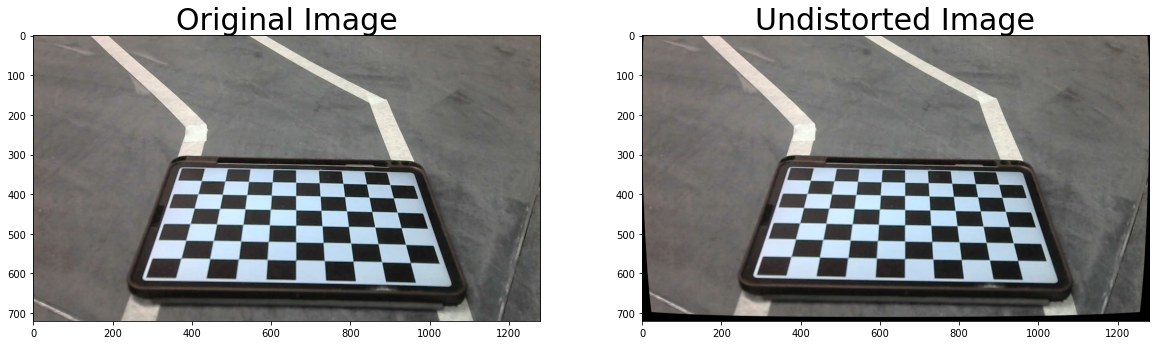

In [147]:
# Undistort image based on camera matrix stored in pickle file.
def undistort(img, cal_dir='cal_pickle.p'):
    with open(cal_dir, mode='rb') as f:
        file = pickle.load(f)
    mtx = file['mtx']
    dist = file['dist']
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    
    return dst


task3 = cv2.imread('chessboard/WIN_20230404_21_28_00_Pro.jpg')
distort = undistort(task3)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(task3)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(distort)
ax2.set_title('Undistorted Image', fontsize=30)


In [148]:
def perspective_warp(img, src, dst):
    img_size = (1280,720)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

def inv_perspective_warp(img, src, dst):
    img_size = (1280,720)
    # Given src and dst points, calculate the perspective transform matrix
    M = cv2.getPerspectiveTransform(src, dst)
    # Warp the image using OpenCV warpPerspective()
    warped = cv2.warpPerspective(img, M, img_size)
    return warped

In [149]:
def point_warp(point, M):
    # convert the point to homogeneous coordinates
    homo = np.array([point[0], point[1], 1]).reshape(-1, 1)
    # apply perspective transform to the point
    warped_point_homo = M @ homo
    warped_point = (warped_point_homo[:2] / warped_point_homo[2]).astype(int)
    return warped_point

def point_unwarp(point, M):
    #inverse back
    M_inv = np.linalg.inv(M)
    point_original_homog = M_inv @ point
    point_original = (point_original_homog[:2] / point_original_homog[2]).astype(int)
    return point_original

Text(0.5, 1.0, 'Warped Image')

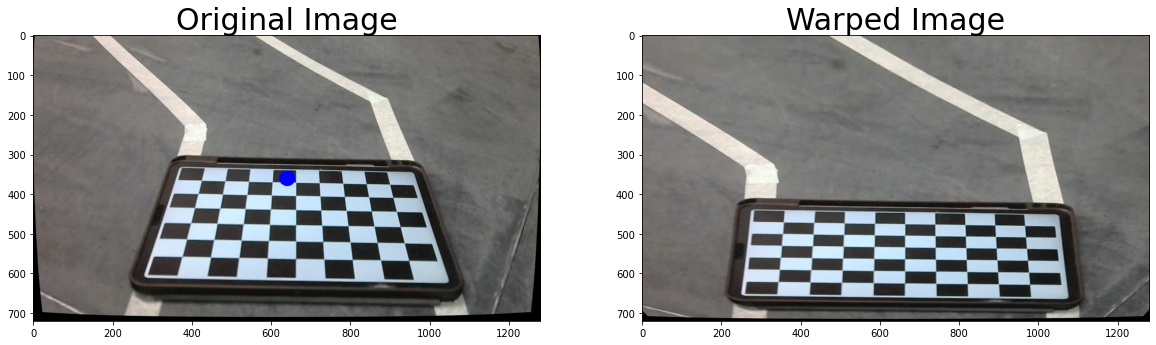

In [150]:
height = distort.shape[0]
width = distort.shape[1]

src_ref=np.float32([(300,0),(1000,0),(0,720),(1280,720)])
dst_ref=np.float32([(0,0), (1280, 0), (0,720), (1280,720)])

M = cv2.getPerspectiveTransform(src_ref, dst_ref)
warp = perspective_warp(distort, src_ref, dst_ref)

center_point = (int(width/2), int(height/2))

cv2.circle(distort, center_point, 5, (0, 0, 255), 30)

# Visualize undistortion
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(distort)
ax1.set_title('Original Image', fontsize=30)
ax2.imshow(warp, cmap='gray')
ax2.set_title('Warped Image', fontsize=30)

In [151]:
def calculate_ratio(img):
    CHESSBOARD_CORNER_NUM_X = 9
    CHESSBOARD_CORNER_NUM_Y = 6
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), None)
    # If found, add object points, image points (after refining them)
    if ret == True:
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        #Draw and display the corners
        cv2.drawChessboardCorners(img, (CHESSBOARD_CORNER_NUM_X,CHESSBOARD_CORNER_NUM_Y), corners2, ret)
    p1 = np.array(corners2[0][0],dtype=np.int32)
    p2 = np.array(corners2[8][0],dtype=np.int32)
    p3 = np.array(corners2[45][0],dtype=np.int32) 
    p4 = np.array(corners2[53][0],dtype=np.int32)

    square_mm = 22.35 #mm
    # y_square_pixel = cv2.norm(p3 - p2)/10
    x_square_pixel = cv2.norm(p3 - p4)/10
    x_pixel_per_mm = x_square_pixel / square_mm
    # y_pixel_per_mm = y_square_pixel / square_mm
    cv2.circle(img,p3,5,(200,0,0),10)
    cv2.line(img,p3,p4,(255,255,255),10)
    plt.figure(figsize = (15, 10)); plt.imshow(img);
    return x_pixel_per_mm

2.83686193447649

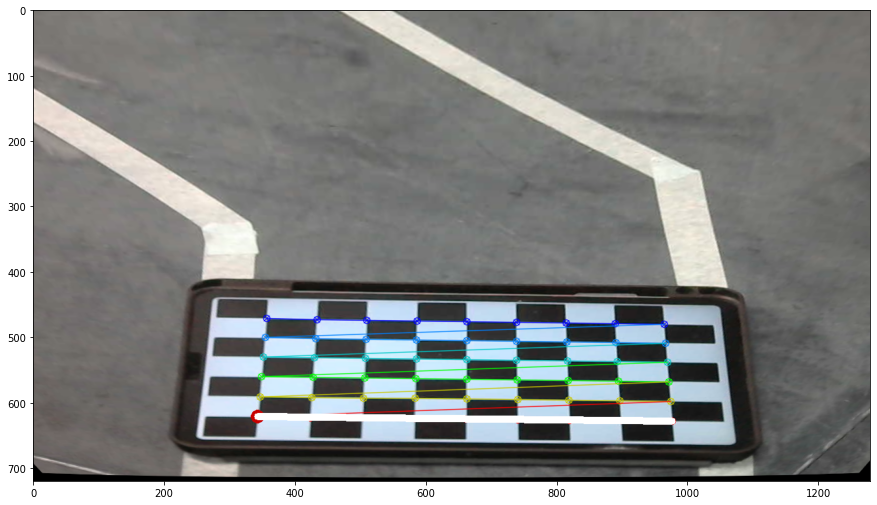

In [152]:
calculate_ratio(warp)
